0. Imports

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

1. Define initial conditions and parameters

In [2]:
# Parameters

# Initial (I0) moments of inertia
I0_f = 0.2
I0_b = 0.2

# Cat Specs
mass_f = 2.0
mass_b = 2.0
cat_half_length = 0.5
cat_length = 2 * cat_half_length

# Other info
time_tot = 1.0
torque_factor = 1.0

# Universal constants
g = -9.81

In [36]:
# Set initial conditions

theta_f_t0 = np.pi
theta_b_t0 = np.pi / 2

omega_f_t0 = np.pi / 8
omega_b_t0 = 0

height_com = 5
velocity_com = 0

state_t0 = [theta_f_t0, omega_f_t0, theta_b_t0, omega_b_t0, height_com, velocity_com]

print(state_t0)

[3.141592653589793, 0.39269908169872414, 1.5707963267948966, 0, 5, 0]


2. Equations of Motion

In [37]:
def cat_aligned(theta1, theta2, threshold):
    '''
    Determines if the cat is aligned enough or if it needs to rotate more
    '''
    angle = abs(theta1 - theta2)

    if angle > threshold:
        return True
    else:
        return False

In [38]:
# Moments of inertia as functions of time and angles
def inertia(t, theta1, theta2):
    '''
    t (float): time in seconds
    theta1, theta2 (floats): orientations of cat halves
    '''
    # I0s
    I1 = I0_f
    I2 = I0_b
    
    # Change inerta so cat rotates
    if not cat_aligned(theta1, theta2, np.pi / 4): 
        I1 *= 1.5 * (1 - 0.5 * np.cos(theta1))  # Modulate front inertia based on angle
        I2 *= 1.5 * (1 + 0.5 * np.cos(theta2))  # Modulate back inertia based on angle
    else:
        I1 *= 1.0
        I2 *= 1.0
    
    # Slightly reduce the front inertia to rotate forward until upright
    I1 *= 0.9 if theta1 < np.pi / 2 else 1.1
    I2 *= 0.9 if theta2 > -np.pi / 2 else 1.1
    
    return I1, I2

In [39]:
def equations(t, state):
    '''
    Inputs:
        t (float): time in seconds
        state (list): theta front, omega front, theta back, omega back, vertical position of total com, velocity of total com
    '''
    theta_f, omega_f, theta_b, omega_b, y_com, v_com = state

    # Calculate moments of inertia for each segment based on the angles
    I_f, I_b = inertia(t, theta_f, theta_b)
    
    # Internal torque based on the difference in angular velocities
    internal_torque = torque_factor * (omega_f - omega_b)

    # Angular accelerations for each segment
    domega_f_dt = internal_torque / I_f
    domega_b_dt = -internal_torque / I_b

    # Center of mass velocity under gravity
    dv_com_dt = g

    return [omega_f, domega_f_dt, omega_b, domega_b_dt, v_com, dv_com_dt]


In [40]:
# Solve ODE
solution = solve_ivp(equations, [0, time_tot], state_t0, t_eval=np.linspace(0, time_tot, 500))

# Extract results
theta_f = solution.y[0]
omega_f = solution.y[1]
theta_b = solution.y[2]
omega_b = solution.y[3]
y_com = solution.y[4]
v_com = solution.y[5]

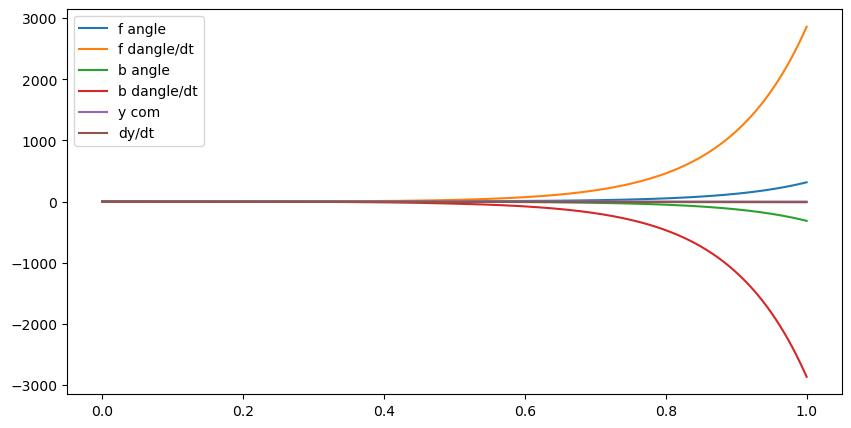

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(solution.t, theta_f, label='f angle')
plt.plot(solution.t, omega_f, label='f dangle/dt')
plt.plot(solution.t, theta_b, label='b angle')
plt.plot(solution.t, omega_b, label='b dangle/dt')
plt.plot(solution.t, y_com, label='y com')
plt.plot(solution.t, v_com, label='dy/dt')
plt.legend()

3. Calculation of Position and Orientation in Time

In [42]:
# Calculate coordinates of center of mass

# COM front
x_com_f = 0.5 * cat_half_length * np.sin(theta_f)
y_com_f = y_com - (cat_half_length / 2) * np.cos(theta_f)

# COM back
x_com_b = -0.5 * cat_half_length * np.sin(theta_b)
y_com_b = y_com - (cat_half_length / 2) * np.cos(theta_b)

# COM total
x_com_tot = ((x_com_f * mass_f) + (x_com_b * mass_b)) / (mass_f + mass_b)
y_com_tot = ((y_com_f * mass_f) + (y_com_b * mass_b)) / (mass_f + mass_b)

In [43]:
# Closer view graph

diff_x_f = x_com_tot - x_com_f
diff_y_f = y_com_tot - y_com_f

diff_x_b = x_com_tot - x_com_b
diff_y_b = y_com_tot - y_com_b

4. Plots Plots Plots

Text(0.5, 1.0, 'Orientation Angles of Cat Segments Over Time')

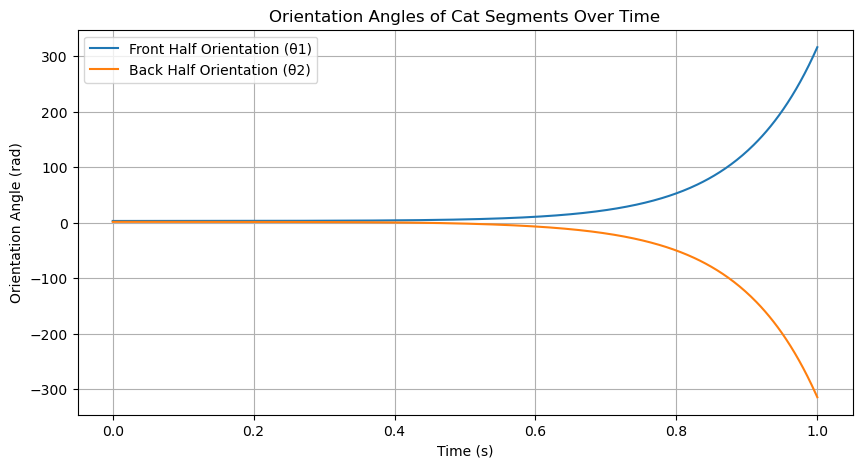

In [44]:
# Angles

plt.figure(figsize=(10, 5))
plt.plot(solution.t, theta_f, label='Front Half Orientation (θ1)')
plt.plot(solution.t, theta_b, label='Back Half Orientation (θ2)')

plt.xlabel('Time (s)')
plt.ylabel('Orientation Angle (rad)')
plt.legend()
plt.grid()
plt.title('Orientation Angles of Cat Segments Over Time')

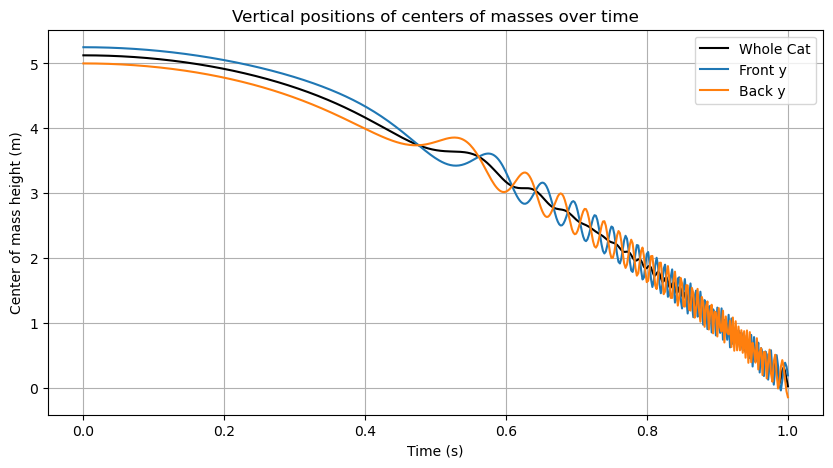

In [45]:
# Center of mass height

plt.figure(figsize=(10, 5))
plt.plot(solution.t, y_com_tot, label='Whole Cat', color='black')
plt.plot(solution.t, y_com_f, label='Front y')
plt.plot(solution.t, y_com_b, label='Back y')

plt.xlabel('Time (s)')
plt.ylabel('Center of mass height (m)')
plt.title('Vertical positions of centers of masses over time')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'T')

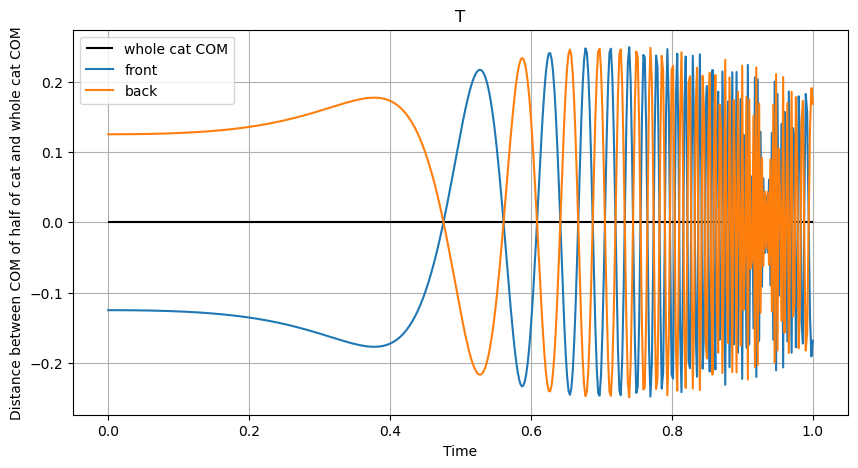

In [46]:
# Plot Center of Mass Trajectory

plt.figure(figsize=(10, 5))
plt.hlines(0, 0, time_tot, label='whole cat COM', color='black')
plt.plot(solution.t, diff_y_f, label='front')
plt.plot(solution.t, diff_y_b, label='back')

plt.xlabel('Time')
plt.ylabel('Distance between COM of half of cat and whole cat COM')
plt.legend()
plt.grid()
plt.title('T')
